In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define simple MLP
class MLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod)
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)
    
def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

In [3]:
class MaskedMLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, hidden_depth,
        default_x,
    ):
        super().__init__()
        self.mask = mask(input_dim, hidden_dim, hidden_depth, output_mod=nn.Sigmoid)
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None)
        self.default_x = default_x
        self.apply(weight_init)

    def forward(self, x):
        mask = self.mask(x)
        masked_x = mask*x + (1 - mask) * self.default_x
        return self.trunk(masked_x)
    
    def mask_loss(self, x):
        mask = self.mask(x)
        return -mask.sum()

def mask(input_dim, hidden_dim, hidden_depth, output_mod=nn.Sigmoid):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, input_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [86]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([0., 0.])
        self.obj1_pos = np.array([0., 0.])
        self.obj1_color = np.array([0., 0., 0.])
        self.obj2_pos = np.array([0., 0.])
        self.obj2_color = np.array([0., 0., 0.])
        self.goal_pos = np.array([0., 0.])
        self.goal_color = np.array([0., 0., 0.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, obj_angles=360, obj_colors=3, discretize=10):
        self.pos = np.array([0., 0.])
        self.obj1_pos, self.obj1_color = self.gen_obj(obj_angles, obj_colors, discretize)
        self.obj2_pos, self.obj2_color = self.gen_obj(obj_angles, obj_colors, discretize)

        # choose goal from random in objects
        goal_obj = random.randint(1, 2)
        if goal_obj == 1:
            self.goal_pos = self.obj1_pos
            self.goal_color = self.obj1_color
        elif goal_obj == 2:
            self.goal_pos = self.obj2_pos
            self.goal_color = self.obj2_color
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_color]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_pos, self.goal_color]))

    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_obs(), reward, False, {}
    
    def dist_to_goal(self, state):
        return np.linalg.norm(state - self.goal_pos)

    # function to generate object based on angles, colors, and discretization ranges
    def gen_obj(self, obj_angles, obj_colors, discretize):
        angle = np.random.uniform(0, obj_angles) # samples angle from range
        angle = round(angle/discretize)*discretize # discretizes to defined range (default 10)
        pos = np.array([5*np.cos(np.deg2rad(angle)), 5*np.sin(np.deg2rad(angle))]) # maps to unit circle
        
        color = np.zeros(shape=obj_colors)
        rand_color = random.randint(0, obj_colors-1) # samples color from range
        color[rand_color] = 1.
        return pos, color

    # function to retrieve plotable color from one-hot encoding
    def get_color(self, color):
        if color[0] == 1.:
            return 'red'
        elif color[1] == 1.:
            return 'blue'
        elif color[2] == 1.:
            return 'green'

In [70]:
def plot_env(env):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter([env.pos[0]],[env.pos[1]], marker='o', color='black', s=30) # plots agent
    plt.scatter([env.obj1_pos[0]],[env.obj1_pos[1]], marker='s', color=env.get_color(env.obj1_color), s=30) # plots obj1
    plt.scatter([env.obj2_pos[0]],[env.obj2_pos[1]], marker='s', color=env.get_color(env.obj2_color), s=30) # plots obj2
    plt.scatter([env.goal_pos[0]],[env.goal_pos[1]], marker='*', color=env.get_color(env.goal_color), s=100) # plots goal

[ 0.          0.         -4.33012702 -2.5         1.          0.
  0.          4.6984631   1.71010072  0.          0.          1.
  0.          0.          1.        ]


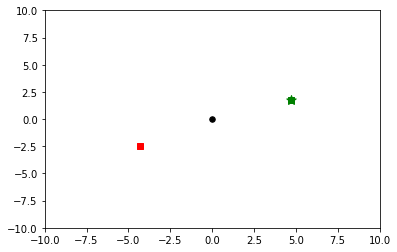

In [71]:
env = PointEnvComplex()
print(env.reset(obj_angles=360, obj_colors=3, discretize=10))
plot_env(env)

In [73]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, obj_angles=360, obj_colors=3, discretize=10):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    trajs = []
    for traj in range(num_trajs):
        env.reset(obj_angles, obj_colors, discretize)
        plot_env(env)
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [], 'next_obs': []}
        delta_vector = env.goal_pos
        o = env.get_obs()
        for i in range(100):
            act = delta_vector * 0.01 # Go in direction between start and end
            no, r, d, _ = env.step(act)
            traj['obs'].append(o.copy())
            traj['acts'].append(act.copy())
            traj['next_obs'].append(no.copy())
            o = no
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['next_obs'] = np.array(traj['next_obs'])
        
        plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        
        trajs.append(traj)
    return trajs

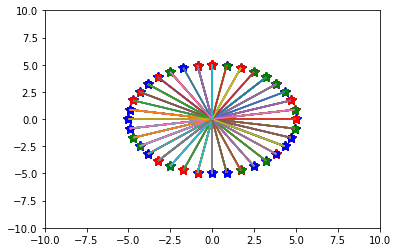

In [76]:
env = PointEnvComplex()
trajs = gen_trajs(env, num_trajs=500, obj_angles=360, obj_colors=3, discretize=10)

In [77]:
# Define the forward model
class Policy(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim, hidden_depth):
        super().__init__()
        self.trunk = mlp(obs_dim, hidden_dim, action_dim, hidden_depth)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, obs):
        next_pred = self.trunk(obs)
        return next_pred

In [83]:
hidden_layer_size = 1000
hidden_depth = 3
horizon = 100
obs_size = env.get_obs().shape[0]
act_size = env.action_space.shape[0]
policy = Policy(obs_size, act_size, hidden_layer_size, hidden_depth)
num_tasks = len(trajs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

Policy(
  (trunk): Sequential(
    (0): Linear(in_features=15, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=2, bias=True)
  )
)

[1,     1] loss: 0.01039217
[2,     1] loss: 0.00320165
[3,     1] loss: 0.00223838
[4,     1] loss: 0.00184149
[5,     1] loss: 0.00164069
[6,     1] loss: 0.00183627
[7,     1] loss: 0.00118329
[8,     1] loss: 0.00150441
[9,     1] loss: 0.00131644
[10,     1] loss: 0.00129083
[11,     1] loss: 0.00105061
[12,     1] loss: 0.00097039
[13,     1] loss: 0.00074586
[14,     1] loss: 0.00096935
[15,     1] loss: 0.00085494
[16,     1] loss: 0.00100823
[17,     1] loss: 0.00090631
[18,     1] loss: 0.00085737
[19,     1] loss: 0.00086190
[20,     1] loss: 0.00079223
[21,     1] loss: 0.00101663
[22,     1] loss: 0.00086806
[23,     1] loss: 0.00108661
[24,     1] loss: 0.00098132
[25,     1] loss: 0.00071269
[26,     1] loss: 0.00058895
[27,     1] loss: 0.00058826
[28,     1] loss: 0.00066207
[29,     1] loss: 0.00070101
[30,     1] loss: 0.00074943
[31,     1] loss: 0.00076501
[32,     1] loss: 0.00049808
[33,     1] loss: 0.00076999
[34,     1] loss: 0.00063294
[35,     1] loss: 0.000

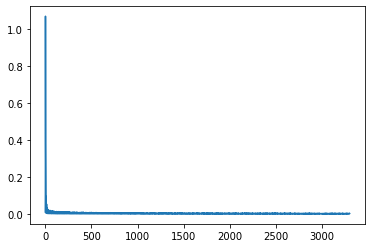

In [84]:
num_epochs = 300
batch_size = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t1_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t1_idx_pertraj = np.random.randint(100, size=(batch_size,))
        t1_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
   
        t1_states = torch.Tensor(t1_states).float().to(device)
        t1_actions = torch.Tensor(t1_actions).float().to(device)
        
        a1_pred = policy(t1_states.to(device)) # action prediction
        
        # mask_loss = policy.mask_loss(t1_states.to(device)) # auxiliary mask loss
        # add in multiplier to mask_loss
        
        loss = torch.mean(torch.linalg.norm(a1_pred - t1_actions, dim=-1)) # supervised learning loss
        # loss += mask_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 10.))
            losses.append(running_loss/10.)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

[4.6984631  1.71010072]
green
0.6716225600244011


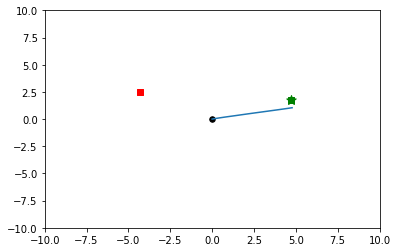

In [119]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

num_test_trajs = 1
dist_to_goals = []
# sets sampling for angles and colors
test_obj_angles = 360
test_obj_colors = 3
discretize = 10

for i in range(num_test_trajs):
    env.reset(test_obj_angles, test_obj_colors, discretize)
    print(env.goal_pos)
    print(env.get_color(env.goal_color))
    plot_env(env)
    o = env.get_obs()
    traj = {'obs': [],'acts': [], 'next_obs': []}
    for i in range(100):
        t1s = torch.Tensor(o[None]).to(device)
        act = policy(t1s).cpu().detach().numpy()[0]
        no, r, d, _ = env.step(act)
        traj['obs'].append(o.copy())
        traj['acts'].append(act.copy())
        traj['next_obs'].append(no.copy())
        o = no.copy()
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['next_obs'] = np.array(traj['next_obs'])
    dist_to_goal = np.linalg.norm(traj['obs'][-1][0:2] - env.goal_pos) # extracts rollout pos and calculates dist to goal
    dist_to_goals.append(dist_to_goal)
    print(dist_to_goal)
    plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs